## PyHHB: Haley edition

Here's my home base for all things PyHHB at the moment.

# 1. Import packages

Import packages and set `rcParams`.

In [13]:
# =============================================================================
# Load packages
# ==============================================================================

import HHB as PyHHB
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units

# 3. Define `SurvLivFull()` function & relevant constants

## 3.1. Defining constants
You might never want any of the following items to change across any hypothetical people or settings, so we can define these constants oustide of any loops. Some of these are immutable constants, facts of life; others could be tinkered with by the user to achieve representations of various diverse peoples and conditions, like resting metabolic rate. In previous PyHHB code, some of these items were defined in a "personal profile" that would be loaded in as a .txt file. Here, we ask the user to supply them in the Jupyter Notebook instead. Be sure to consider each choice carefully before using the SurvLivFull function.

In [14]:
# ----------------- Initial conditions; basal prerequisites -----------------

# ///////////////////////////////////

# Constants that seem pretty immutable to me:

# density
# Density of sweat, in kg / L
# Assumed to be equivalent to that of water. Maybe we can improve upon this assumption later, but it 
# probably wouldn't matter too much.
density = 1

# Lh_vap
# Heat of vaporisation of water at 30⁰C, 2426 J · g ^(-1)
Lh_vap = PyHHB.Lh_vap

# ///////////////////////////////////

# Things the user will want to define on a case-by-case basis:

# Hprod_rest
# Internal heat production at rest, in W / kg

Hprod_rest = 1.8

# ///////////////////////////////////

# Things that were originally defined in a "personal profile" (you can change them if you want, but 
# existing personal profiles may provide you with a good benchmark to start with):

# (I will be taking these example values from Young_adult_livability.txt)

# Tsk_C
# Skin temperature, in degrees C
Tsk_C = 35.0

# Emm_sk
# Area weighted emissivity of the clothed body surface, dimentionless
Emm_sk = 0.98

# W
# External work being done, in W
# In usage of PyHHB thus far, we conservatively assume that the subject is not doing any external work, 
# and is at rest.
W = 0

# Av_ms
# Wind speed (m / s)
Av_ms = 2.68

# ///////////////////////////////////

# Things that are different between survivability and livability

# A_eff
# Effective radiative area of the body, dimentionless
A_eff_surv = 0.70
A_eff_liv = 0.73

# Icl
# Insulation clothing value, in CLO
Icl_surv = 0
Icl_liv = 0.36

# Re_cl
# Evaporative resistance of clothing
Re_cl_surv = 0
Re_cl_liv = 0.01

# ///////////////////////////////////

## 3.2. Define `SurvLivFull()`

The following cell defines the PyHHB model. The user inputs a temperature, humidity, and pressure, and is rewarded with the maximum metabolic rate that a person could achieve in those conditions -- the person in question being defined in the prior cell.

In [15]:
def SurvLivFull(Ta_C, hu, hu_type, PB_kPa = 101.3, sun = "Night-Indoors", old_or_young = 'young', 
                Exp_time = 3, Mmax_only = False):

# This function defines the Python Human Heat Balance Model (PyHHB). See Vanos et al (2023) for more
# information.

# PURPOSE: Given a temperature and humidity, output information about human survivability and livability
#          in those conditions.

# IMPORTANT NOTE: Please read about the following input choices CAREFULLY. Circumstances of heat
#                 exposure (age, exposure time, shade conditions) create large deviations in results.

# INPUT PARAMETERS:

# Ta_C: float or array, near-surface air temperature (C)
# hu: float or array, humidity in either specific humidity (dimensionless) or RH (dimensionless)
# hu_type: str, describes given humidity metric, 'q' or 'rh'. IMPORTANT NOTE: If using RH, your input 
#          should be between 0 and 1! Do NOT use a percentage!
# PB_kPa: barometric pressure in kPa; defaults to 101.3 kPa
# Av_ms: Wind speed (m / s); defaults to 1 m / s
# sun: str, describes sunlight conditions, 'Night-Indoors' or 'Day-Outdoors'; defaults to 
#      'Night-Indoors'.
# old_or_young: str, choose whether you wish to consider a healthy young adult (aged 18-45) or an old 
#               adult (65+), 'old' or 'young'. Defaults to 'young'.
# Exp_time: int, exposure time, in hours. Right now, PyHHB is only configured for exposure times of 3 or
#           6 hours. Don't use input other than 3 or 6. Choose whichever option is appropriate for the
#           model output you're applying PyHHB to (if model output is your usecase). Defaults to 3.

# Default conditions assume a most optimistic scenario.

# OUTPUT PARAMETERS:

# (will fill this in later if I have more time)

# FIRST: Data preprocessing & defining of constants.
# Some constants will change based on parameters the user has defined. Let's define them now.
# Additionally, we will need to put temperature and humidity into NumPy arrays if they aren't already.

    if old_or_young == 'old':

        # person_condition
        # Maximum skin wettedness based on condition
        # The maximum skin wettedness of a person changes depending on heat acclimation status. Here are
        # some values from the PyHHB documentation:

        #     ISO:
        #     Unacclimated = 0.85
        #     Acclimatied = 1.00

        #     Ravanelli et al. MSSE (2018):
        #     Untrained & Unacclimated = 0.72
        #     Trained & Unacclimated = 0.84
        #     Trained & Acclimated = 0.95

        #     Morris 2015
        #     YNG Morris 2015 = 0.65
        #     OLD Morris 2015 = 0.5

        # The relevant PyHHB function, PyHHB.wmax(), recognizes the following strings as valid values of
        # person_condition:

        # 'Unacclimated'
        # 'fully acclimated'
        # 'Untrained & Unacclimated'
        # 'Trained & Unacclimated'
        # 'Trained & Acclimated'
        # 'YNG_Morris_2021'
        # 'OLD_Morris_2021'

        person_condition = "OLD_Morris_2021"

        # Mass, in kg
        Mass = 73.9

        # Height, in m
        # This can be set to -9999 to indicate you'd rather define a specific value for AD in the 
        # personal profile.
        Height = -9999

        # AD
        # Corporeal surface area, in m ^ 2; can either be given in a personal profile or estimated from
        # mass and height
        AD = 1.78
        # AD = PyHHB.AD_from_mass_height(Mass, Height)

        # Smax
        # Maximum sweat rate, in L · h ^ (-1).
        Smax = 0.51

    elif old_or_young == 'young':

        # person_condition
        # Maximum skin wettedness based on condition
        # The maximum skin wettedness of a person changes depending on heat acclimation status. Here are
        # some values from the PyHHB documentation:

        #     ISO:
        #     Unacclimated = 0.85
        #     Acclimatied = 1.00

        #     Ravanelli et al. MSSE (2018):
        #     Untrained & Unacclimated = 0.72
        #     Trained & Unacclimated = 0.84
        #     Trained & Acclimated = 0.95

        #     Morris 2015
        #     YNG Morris 2015 = 0.65
        #     OLD Morris 2015 = 0.5

        # The relevant PyHHB function, PyHHB.wmax(), recognizes the following strings as valid values of
        # person_condition:

        # 'Unacclimated'
        # 'fully acclimated'
        # 'Untrained & Unacclimated'
        # 'Trained & Unacclimated'
        # 'Trained & Acclimated'
        # 'YNG_Morris_2021'
        # 'OLD_Morris_2021'

        person_condition = "YNG_Morris_2021"

        # Mass, in kg
        Mass = 56.2

        # Height, in m
        # This can be set to -9999 to indicate you'd rather define a specific value for AD in the 
        # following line.
        Height = -9999

        # AD
        # Corporeal surface area, in m ^ 2; can either be given manually below or estimated from
        # mass and height using a PyHHB function
        AD = 1.6
        # AD = PyHHB.AD_from_mass_height(Mass, Height)

        # Smax
        # Maximum sweat rate, in L · h ^ (-1).
        Smax = 0.75
        
    # Now that we know all that, we can calculate a couple more constants.
    
    # ///////////////////////////////////

    # M
    # Metabolic rate
    # We assume the metabolic rate of a person is 1.8 W / kg. Hprod_rest = M - W, and in usage of PyHHB so 
    # far, we assume W = 0. As such, M = Hprod_rest most of the time.
    # UPDATE 1/21/24: This is used to be a fixed number defined earlier in the cell, but now it's dependent
    # on Hprod_rest and Mass.
    M = Hprod_rest * Mass

    # M_rest
    # Resting metabolic rate; metabolic energetic expenditure while people are resting, in W.
    M_rest = Hprod_rest * Mass
    
    # Now, see if we need to change the type of Ta_C and hu.

    if type(Ta_C) == int or type(Ta_C) == float or type(Ta_C) == list:
        Ta_C = np.array([Ta_C])
        
    if type(hu) == int or type(hu) == float or type(hu) == list:
        hu = np.array([hu])
        
    # If we were given specific humidity, it will need to be converted to RH. Before we do that, though, we
    # need to calculate the mixing ratio.
    # UPDATE 1/21/24: Mixing ratio is a new necessary component of the model

    if hu_type == 'q':
        
        # mixing_ratio
        mixing_ratio = mpcalc.mixing_ratio_from_specific_humidity(hu)
        
        RH = mpcalc.relative_humidity_from_specific_humidity(PB_kPa * units.kPa, Ta_C * units.degC, 
                                                             hu)
        
    elif hu_type == 'rh':
        
        # mixing ratio
        mixing_ratio = mpcalc.mixing_ratio_from_relative_humidity(PB_kPa * units.kPa, Ta_C * units.degC,
                                                                  hu)
        
        # print("mixing_ratio: " + str(mixing_ratio))
        
        RH = hu

    # ///////////////////////////////////

    # Things that need to be calculated/require knowledge of prior constants and choices and WILL change as
    # a result of climatic variables, but require no extra input than what we've given already:

    # mrt_C
    # Mean radiant temperature, in C
    # mrt_C is Ta_C if indoors and Ta_C + 15 if outdoors. 

    if sun == "Night-Indoors":
        mrt_C = Ta_C
    elif sun == "Day-Outdoors":
        mrt_C = Ta_C + 15
        
    # SECOND: Run the model.

    # The following code is separated into "tiers." All the information from a higher tier is necessary
    # to calculate values in a lower tier.

    # ----------------- Tier 8 -----------------

    # hr_cof_from_radiant_features
    # UPDATE 1/21/24: Needs two branches for survivability and livability
    hr_cof_from_radiant_features_surv = PyHHB.hr_cof_from_radiant_features(mrt_C, Tsk_C, Emm_sk, 
                                                                           A_eff_surv)
    hr_cof_from_radiant_features_liv = PyHHB.hr_cof_from_radiant_features(mrt_C, Tsk_C, Emm_sk, 
                                                                          A_eff_liv)
    
    # hc_cof_from_Av
    hc_cof_from_Av = PyHHB.hc_cof_from_Av(Av_ms)
    
    # Psa_kPa_from_TaC
    Psa_kPa_from_TaC = PyHHB.Psa_kPa_from_TaC(Tsk_C)
    
    # ----------------- Tier 7 -----------------

    # to_from_hr_tr_hc_ta
    # UPDATE 1/21/24: Needs two branches for survivability and livability
    to_from_hr_tr_hc_ta_surv = PyHHB.to_from_hr_tr_hc_ta(hr_cof_from_radiant_features_surv, mrt_C, 
                                                         hc_cof_from_Av, Ta_C)
    to_from_hr_tr_hc_ta_liv = PyHHB.to_from_hr_tr_hc_ta(hr_cof_from_radiant_features_liv, mrt_C, 
                                                        hc_cof_from_Av, Ta_C)
        
    # h_coef_from_hc_hr
    # UPDATE 1/21/24: Needs two branches for survivability and livability
    h_coef_from_hc_hr_surv = PyHHB.h_coef_from_hc_hr(hc_cof_from_Av, hr_cof_from_radiant_features_surv)
    h_coef_from_hc_hr_liv = PyHHB.h_coef_from_hc_hr(hc_cof_from_Av, hr_cof_from_radiant_features_liv)
    
    # vapor_pressure
    # UPDATE 1/21/24: Now metpy function rather than PyHHB function
    # Pv_kPa_from_Psa_RH = PyHHB.Pv_kPa_from_Psa_RH(Psa_kPa_from_TaC, RH)
    vapor_pressure = mpcalc.vapor_pressure(PB_kPa * units.kPa, mixing_ratio).magnitude
    
    # ----------------- Tier 6 -----------------

    # Dry_Heat_Loss_c_plus_r
    # UPDATE 1/21/24: Needs two branches for survivability and livability
    Dry_Heat_Loss_c_plus_r_surv = PyHHB.Dry_Heat_Loss_c_plus_r(Tsk_C, to_from_hr_tr_hc_ta_surv, 
                                                               Icl_surv, h_coef_from_hc_hr_surv, AD)
    Dry_Heat_Loss_c_plus_r_liv = PyHHB.Dry_Heat_Loss_c_plus_r(Tsk_C, to_from_hr_tr_hc_ta_liv, Icl_liv,
                                                              h_coef_from_hc_hr_liv, AD)

    # Cres_from_M_Ta
    Cres_from_M_Ta = PyHHB.Cres_from_M_Ta(M, Ta_C, AD)

    # Eres_from_M_Pa
    # UPDATE 1/21/24: Now takes vapor_pressure rather than Pv_kPa_from_Psa_RH
    Eres_from_M_Pa = PyHHB.Eres_from_M_Pa(M, vapor_pressure, AD)
    
    # he_cof
    he_cof = PyHHB.he_cof(hc_cof_from_Av)
    
# ----------------- Tier 5 -----------------

    # Ereq_from_HeatFluxes
    # UPDATE 1/21/24: Needs two branches for survivability and livability
    Ereq_from_HeatFluxes_surv = PyHHB.Ereq_from_HeatFluxes(M, W, Dry_Heat_Loss_c_plus_r_surv, 
                                                           Cres_from_M_Ta, Eres_from_M_Pa)
    Ereq_from_HeatFluxes_liv = PyHHB.Ereq_from_HeatFluxes(M, W, Dry_Heat_Loss_c_plus_r_liv, 
                                                          Cres_from_M_Ta, Eres_from_M_Pa)
    # Emax_env
    # UPDATE 1/21/24: Now takes vapor_pressure instead of Pv_kPa_from_Psa_RH
    #                 Needs two branches for survivability and livability
    Emax_env_surv = PyHHB.Emax_env(Psa_kPa_from_TaC, vapor_pressure, Re_cl_surv, he_cof, Icl_surv, AD)
    Emax_env_liv = PyHHB.Emax_env(Psa_kPa_from_TaC, vapor_pressure, Re_cl_liv, he_cof, Icl_liv, AD)
    
    Emax_env_surv[Emax_env_surv<0] = 0
    Emax_env_liv[Emax_env_liv<0] = 0
    
# ----------------- Tier 4 -----------------
    # wreq_HSI_skin_wettedness
    # UPDATE 1/21/24: Needs two branches for survivability and livability
    wreq_HSI_skin_wettedness_surv = PyHHB.wreq_HSI_skin_wettedness(Ereq_from_HeatFluxes_surv, 
                                                                   Emax_env_surv)
    
    wreq_HSI_skin_wettedness_liv = PyHHB.wreq_HSI_skin_wettedness(Ereq_from_HeatFluxes_liv, 
                                                                  Emax_env_liv)
    
# ----------------- Tier 3 -----------------

    # wmax
    wmax = PyHHB.wmax(person_condition)
    
    # 4. Sweating_efficiency_r
    # UPDATE 1/21/24: Needs two branches for survivability and livability
    Sweating_efficiency_r_surv = PyHHB.Sweating_efficiency_r(wreq_HSI_skin_wettedness_surv)
    Sweating_efficiency_r_liv = PyHHB.Sweating_efficiency_r(wreq_HSI_skin_wettedness_liv)
    
# ----------------- Tier 2 -----------------

    # Emax_wettedness
    # UPDATE 1/21/24: Now takes vapor_pressure instead of Pv_kPa_from_Psa_RH
    #                 Needs two branches for survivability and livability
    # Emax_wettedness = PyHHB.Emax_wettedness(wmax, Psa_kPa_from_TaC, vapor_pressure, Re_cl, he_cof,
    #                                         Icl, AD)
    Emax_wettedness_surv = PyHHB.Emax_wettedness(wmax, Psa_kPa_from_TaC, vapor_pressure, Re_cl_surv, 
                                                 he_cof, Icl_surv, AD)
    Emax_wettedness_liv = PyHHB.Emax_wettedness(wmax, Psa_kPa_from_TaC, vapor_pressure, Re_cl_liv, 
                                                he_cof, Icl_liv, AD)

    # Emax_sweat_rate
    # UPDATE 1/21/24: Needs two branches for survivability and livability
    Emax_sweat_rate_surv = PyHHB.Emax_sweat_rate(Smax, Lh_vap, density, Sweating_efficiency_r_surv)
    Emax_sweat_rate_liv = PyHHB.Emax_sweat_rate(Smax, Lh_vap, density, Sweating_efficiency_r_liv)

    # Sreq
    # UPDATE 1/21/24: Needs two branches for survivability and livability
    Sreq_surv = PyHHB.Sreq(Ereq_from_HeatFluxes_surv, Sweating_efficiency_r_surv, Lh_vap)

    Sreq_liv = PyHHB.Sreq(Ereq_from_HeatFluxes_liv, Sweating_efficiency_r_liv, Lh_vap)
    
# ----------------- Tier 1 -----------------

    # survivability
    survivability, flag_survivability = PyHHB.Survivability(Exp_time, Ereq_from_HeatFluxes_surv, 
                                                            Emax_wettedness_surv, Emax_sweat_rate_surv,
                                                            Sreq_surv, Smax, Mass)
    
# ----------------- Tier 0 -----------------
# ----------------- ULTIMATE GOAL: OBTAIN LIVABILITY -----------------

    Mmax, mask_non_livable = PyHHB.livability_Mmax(survivability, Ereq_from_HeatFluxes_liv, 
                                                   Emax_wettedness_liv, Emax_sweat_rate_liv, M_rest)
    
    # Extra: Convert Mmax from W to METs

    Mmax = PyHHB.MetabolicRate_W_to_MET_Mass(Mmax, Mass)
    
    if Mmax_only == True:
        
        return Mmax
    
    else:
    
        return survivability, flag_survivability, Mmax, mask_non_livable

Let's do a test run of this function on some random conditions, just to make sure it works.

In [16]:
survivability, flag_survivability, Mmax, mask_non_livable = SurvLivFull(33.89, .4, 'rh', PB_kPa = 101.0, 
                                                                        old_or_young = 'young', sun = 'Day-Outdoors')

print("Survivable?")
print(survivability)
print("Survivability flag:")
print(flag_survivability)
print("Mmax:")
print(Mmax)
print("Survivable but not livable?")
print(mask_non_livable)

Survivable?
[ True]
Survivability flag:
[1.]
Mmax:
[4.50852736]
Survivable but not livable?
[False]


In [ ]:
print("This is the end of the file")

In [ ]:
print("This is STILL the end of the file there's nothing after this")

In [17]:
# =============================================================================
# Creation of new arrays to storage the information from the following iteration
# =============================================================================

Mmax_future = np.ones(ta_future.shape) * np.nan
warm_time_future = np.ones(ta_future.shape[1:]) * np.nan
total_sbnl_flag_future = np.ones(ta_future.shape[1:]) * np.nan

mmax50_future = np.ones(ta_future.shape[1:]) * np.nan

#________To have input data analysis (remember this are t>threshold)___________
hus_50_future = np.ones(ta_future.shape[1:]) * np.nan

ta_50_future = np.ones(ta_future.shape[1:]) * np.nan

ps_50_future = np.ones(ta_future.shape[1:]) * np.nan

In [18]:
all_future = xr.combine_by_coords([ta_future, hus_future, ps_future])

Let's subset the data to only points where temperature is above a certain threshold and convert our variables to where we need them to be, unit-wise.

In [19]:
%%time

all_future = all_future.where(all_future['tas'] > Tair_threshold + 273.15)
all_future['tas'] = all_future['tas'] - 273.15
all_future['ps'] = all_future['ps'] / 1000

CPU times: total: 1min 48s
Wall time: 3min 55s


### range test

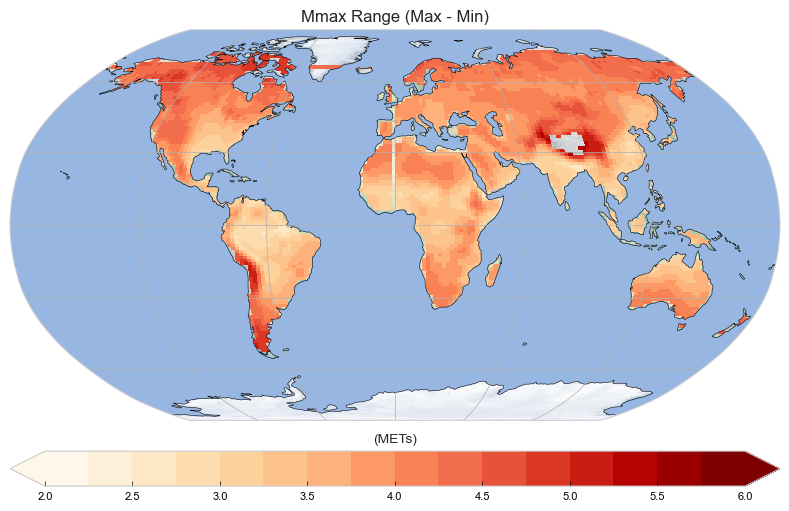

In [48]:
lat_min = -60
lat_max = 75
lon_min = 0
lon_max = 360
longitudes = data.coords['lon'].sel(lon = slice(lon_min, lon_max)).values
longitudes = (longitudes + 180) % 360 - 180
latitudes = data.coords['lat'].sel(lat = slice(lat_min, lat_max)).values

img_extent = (lon_min, lon_max, lat_min, lat_max)
# title = model + '.ssp' + ssp + '.' + person_condition + '.tover' + str(Tair_threshold)
title_colorbar = '(METs)'
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson()) # ,extent=img_extent
ax.stock_img()
ax.coastlines(lw = 0.4)

data = np.array(mmax_MIROC_f_lowres.mmax50_future.values)

data = np.ma.array(data, mask = np.isnan(data))

levels = np.arange(2, 6.25, 0.25)
cmap = plt.get_cmap('plasma_r')

norm = BoundaryNorm(levels, ncolors = cmap.N, clip = True)
filled_c = ax.pcolormesh(longitudes, latitudes, data, 
                         transform = ccrs.PlateCarree(), cmap = 'OrRd', norm = norm)
# filled_c = ax.pcolormesh(longitudes, latitudes, np.array(mean_future.values), 
#                          transform = ccrs.PlateCarree(), cmap = 'plasma_r', norm = norm)

# ax.add_feature(cfeature.OCEAN, zorder = 1)  #zorder > 10

# ax.contourf(longitudes, latitudes, significance, levels = [-0.01, 0.5, 1.0],
#             hatches = ["", 5 * "."], alpha = 0, transform = ccrs.PlateCarree(), lw = 0.5)
  
clb = plt.colorbar(filled_c, orientation = 'horizontal', extend = 'both', pad = 0.04) # ,cax = ax)
clb.ax.tick_params(labelsize = 8) 
clb.ax.set_title(title_colorbar, fontsize = 10)

gl = ax.gridlines(draw_labels = False, linewidth = 0.5)
gl.top_labels = False; gl.left_labels = False

ax.add_feature(cfeature.OCEAN, zorder = 1)

plt.title("Mmax Range (Max - Min)", fontsize = 12)
fig.tight_layout()
plt.savefig(workdir + 'latest_PyHHB/outputs/Figures/avg/range_avg.png', dpi = 600, transparent = False, 
            bbox_inches = 'tight')
# legend_elements = [Patch(facecolor = (0, 0, 0, 0), edgecolor = 'k', hatch = '...', 
#                          label = 'Statistically significant p < 0.05')]
# plt.legend(handles = legend_elements, bbox_to_anchor = (0.85, -0.1), fontsize = 10, ncol = 1)